In [1]:
import pandas as pd
import statsmodels.api as sm
from scipy.stats import skew, kurtosis

/Users/wolong/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


HW2: team -  Wo Long, Zhiyuan Li

## Q1

#### 1.1

### Mean Calculation:
Given the return equation:
$$ r_t = \mu + \sigma\epsilon_t + B_t\mu_J + B_t\sigma_J\delta_t $$
With $\epsilon_t , \delta_t \sim N(0,1)$ and $E(B_t\delta_t) = 0$ due to independence, we find the expected value of $r_t$ as:
$$ E(r_t) = \mu + \mu_Jp $$

### Variance Calculation:
The variance of $r_t$ can be expressed as:
$$ var(r_t) = \sigma^2 + \mu_J^2p(1-p) + \sigma_J^2p $$

### Skewness Calculation:
For skewness, we first define the deviation of $r_t$ from its mean:
$$ r_t - E(r_t) = \sigma\epsilon_t + (B_t - p)\mu_J + \sigma_JB_t\delta_t$$
The third moment of this deviation is given by:
$$ E[(r_t - E(r_t))^3] = p(1-p)\mu_J[\mu_J^2(1-2p)+3\sigma_J^2] $$
Thus, the skewness is:
$$ Skewness = \frac{E[(r_t - E(r_t))^3]}{var(r_t)^{3/2}} = \frac{p(1-p)\mu_J[\mu_J^2(1-2p)+3\sigma_J^2]}{(\sigma^2 + \mu_J^2p(1-p)+\sigma_J^2 p)^{3/2}} $$

### Excess Kurtosis Calculation:
The fourth moment of the deviation of $r_t$ from its mean is:
$$ E[(r_t - E(r_t))^4] = 3\sigma^4 + \mu_J^4(p-4p^2+6p^3-3p^4) + 3p\sigma_J^4 + 6\sigma^2\mu_J^2p(1-p) + 6\sigma^2\sigma_J^2p + 6\mu_J^2\sigma_J^2p(1-p)^2 $$
Hence, the excess kurtosis is:
$$ Excess \ Kurtosis = \frac{3\sigma^4 + \mu_J^4(p-4p^2+6p^3-3p^4) + 3p\sigma_J^4 + 6\sigma^2\mu_J^2p(1-p) + 6\sigma^2\sigma_J^2p + 6\mu_J^2\sigma_J^2p(1-p)^2 - 3[\sigma^2 + \mu_J^2p(1-p)+\sigma_J^2 p]^2}{[\sigma^2 + \mu_J^2p(1-p)+\sigma_J^2 p]^2} $$
$$ = p(1-p)\frac{\mu_J^4(1-6(1-p)p) + 6\mu_J^2\sigma_J^2(1-2p) + 3\sigma_J^4}{[\sigma^2 + \mu_J^2p(1-p)+\sigma_J^2 p]^2} $$


#### 1.2

Under the log normal model, log-return are normally distributed, which don't have any skewness and excess kurtosis. But in reality, the market log-return has skewnnes and fat tail. Using a Bernoulli-normal mixture jump can better model these effects.

The Bernoulli-normal mixture model can potentially provide a more accurate representation of returns compared to the log-normal model, primarily due to its ability to model skewness and excess kurtosis. In the log-normal model, log returns are assumed to follow a normal distribution, which inherently suggests that they have zero skewness and zero excess kurtosis. However, financial returns often exhibit non-normal characteristics, such as skewness and kurtosis, which the log-normal model fails to capture. The Bernoulli-normal mixture model addresses this limitation by allowing for the incorporation of these features, leading to a potentially more realistic and nuanced understanding of return distributions.

### 1.3

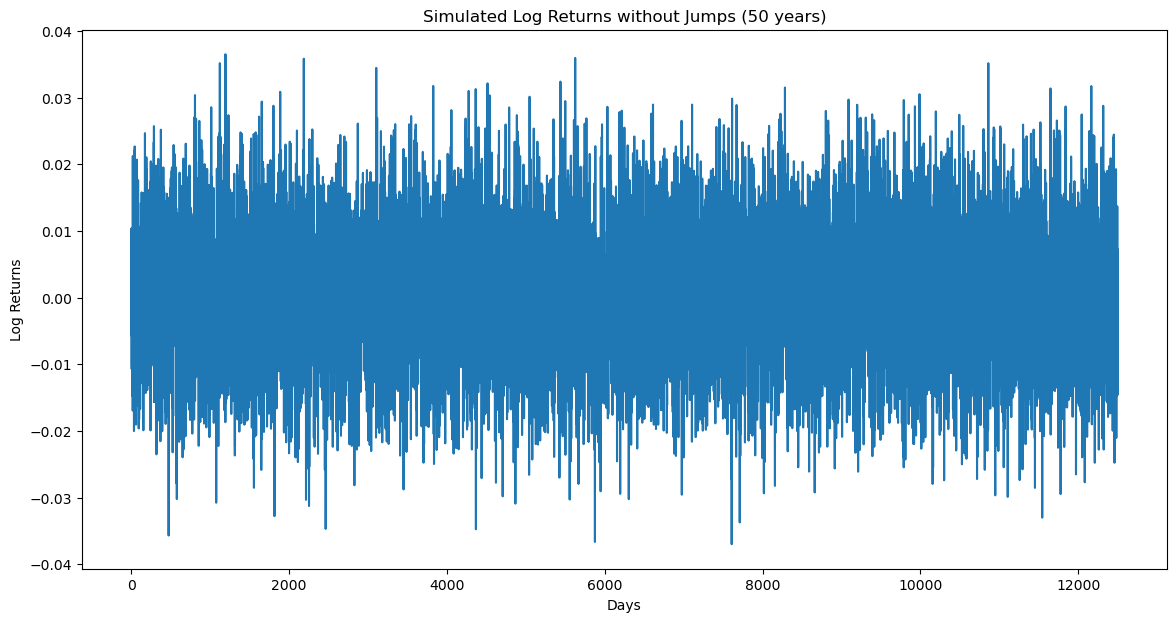

In [2]:
import numpy as np
import matplotlib.pyplot as plt

mu = 0.0004
sigma = 0.01
observations = 12500  

log_returns_iid = np.random.normal(mu, sigma, observations)

plt.figure(figsize=(14, 7))
plt.plot(log_returns_iid)
plt.title('Simulated Log Returns without Jumps (50 years)')
plt.xlabel('Days')
plt.ylabel('Log Returns')
plt.show()


This does not look like real stock return data. The sudden jump is missing and it should be skewed as well

$$ r_t = \mu + \sigma\epsilon_t + B_t\mu_J + B_t\sigma_J\delta_t $$

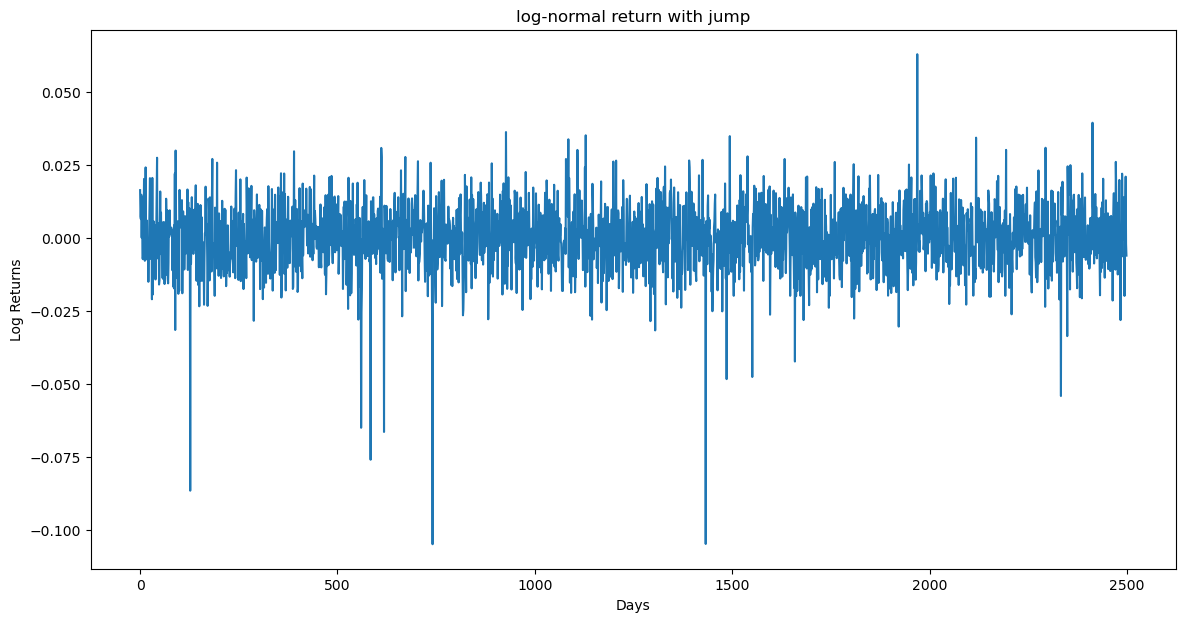

In [19]:
T = 2500
(μ, sigma, p, mu_j, sigma_j ) = (0.0004, 0.01, 0.01, -0.03 , 0.04)
eps = np.random.normal(0, sigma, T)
B = np.random.binomial(1, p, T)
delta = np.random.normal(0, sigma_j, T)
r = mu + eps + mu_j*B + B*delta

plt.figure(figsize=(14, 7))
plt.plot(r)
plt.title('log-normal return with jump')
plt.xlabel('Days')
plt.ylabel('Log Returns')
plt.show()

In [20]:
mean_r = np.mean(r)
std_r = np.std(r)
skewness_r = skew(r)
kurtosis_r = kurtosis(r, fisher=True)  # Fisher's definition (subtract 3)

mean_r, std_r, skewness_r, kurtosis_r

(0.0003057426749989486,
 0.011335447524069652,
 -1.0773947309208725,
 9.180293703461874)

Now it looks way better. The log-return has more jumps and the jumps are left skewed, which is closer to the reality.

### 1.4

In [5]:
import scipy.stats as stats
mu_J = mu_j
sigma_J = sigma_j

In [6]:
def simulate_jumps(T):
    daily_observations = int(T * 250)  
    log_returns_sample = np.zeros(daily_observations)

    for t in range(daily_observations):
        Bt = np.random.binomial(1, p)  
        epsilon_t = np.random.normal(0, 1) 
        delta_t = np.random.normal(0, 1)  
        Jt = Bt * (mu_J + sigma_J * delta_t)  
        log_returns_sample[t] = mu + sigma * epsilon_t + Jt  

    return log_returns_sample

def simulate_t_stats(N, T):
    sample_means = np.zeros(N)
    t_stats = np.zeros(N)
    standard_errors = np.zeros(N)

    for i in range(N):
        sample = simulate_jumps(T)
        sample_mean = np.mean(sample)
        sample_std = np.std(sample, ddof=1)  
        standard_error = sample_std / np.sqrt(len(sample))
        t_stat = sample_mean / standard_error

        sample_means[i] = sample_mean
        t_stats[i] = t_stat
        standard_errors[i] = standard_error

    return {
        'mean_t_stats': np.mean(t_stats),
        'std_dev_t_stats': np.std(t_stats),
        'skewness_t_stats': stats.skew(t_stats),
        'kurtosis_t_stats': stats.kurtosis(t_stats),
        'mean_sample_means': np.mean(sample_means),
        'std_dev_sample_means': np.std(sample_means),
        'skewness_sample_means': stats.skew(sample_means),
        'kurtosis_sample_means': stats.kurtosis(sample_means),
        'average_standard_error': np.mean(standard_errors),
        'std_dev_sample_means_est': np.std(sample_means),
        't_stat JB test': (stats.skew(t_stats)**2)/(6/N) + ((stats.kurtosis(t_stats) - 3)**2)/(24/N),
        'sample mean JB test': (stats.skew(sample_means)**2)/(6/N) + ((stats.kurtosis(sample_means) - 3)**2)/(24/N)
    }



In [7]:
N = 1000
T_values = [0.10, 0.50, 1, 2, 4]

results = {}

for T in T_values:
    results[T] = simulate_t_stats(N, T)




In [8]:
results = pd.DataFrame(results)
results

,0.1,0.5,1.0,2.0,4.0
mean_t_stats,0.088870,0.130811,0.154481,0.209201,0.332417
std_dev_t_stats,1.060718,1.009968,1.030175,1.005328,1.020883
skewness_t_stats,0.288506,0.006453,0.063873,0.186689,-0.010113
kurtosis_t_stats,0.160068,-0.136582,-0.113354,0.270883,-0.221855
mean_sample_means,0.000053,0.000095,0.000083,0.000092,0.000111
std_dev_sample_means,0.002236,0.000990,0.000721,0.000500,0.000358
skewness_sample_means,-0.154840,-0.163697,-0.154808,0.042168,-0.089122
kurtosis_sample_means,0.278211,0.012130,0.035557,0.277638,-0.185249
average_standard_error,0.002144,0.000985,0.000701,0.000498,0.000352
std_dev_sample_means_est,0.002236,0.000990,0.000721,0.000500,0.000358


Because the generated data are iid, the convergence to normal is very quick.

## Q2

#### 2.1


In [9]:
df = pd.read_csv("homework3data.csv")
df

,month,year,nfirms,me,div_yld,log_excess_ret
0,1,1960,1088,2.850929e+08,0.033025,-0.072275
1,2,1960,1092,2.881785e+08,0.033130,0.010698
2,3,1960,1096,2.841433e+08,0.033801,-0.016199
3,4,1960,1096,2.795177e+08,0.034413,-0.018143
4,5,1960,1098,2.877926e+08,0.033933,0.030841
...,...,...,...,...,...,...
715,8,2019,5790,3.569314e+10,0.020298,-0.022818
716,9,2019,5791,3.613702e+10,0.020988,0.014316
717,10,2019,5796,3.676597e+10,0.020780,0.017479
718,11,2019,5787,3.797147e+10,0.019998,0.034116


In [10]:
df['r_t+1'] = df['log_excess_ret'].shift(-1) * 12
df

,month,year,nfirms,me,div_yld,log_excess_ret,r_t+1
0,1,1960,1088,2.850929e+08,0.033025,-0.072275,0.128371
1,2,1960,1092,2.881785e+08,0.033130,0.010698,-0.194394
2,3,1960,1096,2.841433e+08,0.033801,-0.016199,-0.217720
3,4,1960,1096,2.795177e+08,0.034413,-0.018143,0.370098
4,5,1960,1098,2.877926e+08,0.033933,0.030841,0.238060
...,...,...,...,...,...,...,...
715,8,2019,5790,3.569314e+10,0.020298,-0.022818,0.171787
716,9,2019,5791,3.613702e+10,0.020988,0.014316,0.209743
717,10,2019,5796,3.676597e+10,0.020780,0.017479,0.409388
718,11,2019,5787,3.797147e+10,0.019998,0.034116,0.320975


In [11]:
X = sm.add_constant(df['div_yld'][:-1])
Y = df['r_t+1'][:-1]
X,Y

(     const   div_yld
 0      1.0  0.033025
 1      1.0  0.033130
 2      1.0  0.033801
 3      1.0  0.034413
 4      1.0  0.033933
 ..     ...       ...
 714    1.0  0.019863
 715    1.0  0.020298
 716    1.0  0.020988
 717    1.0  0.020780
 718    1.0  0.019998
 
 [719 rows x 2 columns],
 0      0.128371
 1     -0.194394
 2     -0.217720
 3      0.370098
 4      0.238060
          ...   
 714   -0.273815
 715    0.171787
 716    0.209743
 717    0.409388
 718    0.320975
 Name: r_t+1, Length: 719, dtype: float64)

In [12]:
model = sm.OLS(Y, X).fit(cov_type='HC0') 
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  r_t+1   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.258
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.262
Time:                        01:11:27   Log-Likelihood:                -558.74
No. Observations:                 719   AIC:                             1121.
Df Residuals:                     717   BIC:                             1131.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0211      0.065     -0.325      0.746      -0.148       0.106
div_yld        2.5456      2.270      1.122      0.262      -1.903       6.994
==============================================================================
Omnibus:                      119.913   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              323.841
Skew:                          -0.845   Prob(JB):                     4.77e-71
Kurtosis:                       5.820   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

Since P value for div_yld is 0.262, we can not reject the null that the coef for div_yld = 0. i.e. we can't reject that there is no predictablility of div_yld.

#### 2.2

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson

data = pd.read_csv("homework3data.csv")
data['future_returns'] = data['log_excess_ret'].shift(-1) * 12

independent_vars = sm.add_constant(data['div_yld'][:-1])
dependent_var = data['future_returns'].dropna()

vif = [variance_inflation_factor(independent_vars.values, i) for i in range(independent_vars.shape[1])]
bp_test_stat, bp_pvalue, _, _ = het_breuschpagan(model.resid, model.model.exog)
white_test_stat, white_pvalue, _, _ = het_white(model.resid, model.model.exog)

print(f"VIF: {vif}")
print(f"Breusch-Pagan test: Stat={bp_test_stat}, p-value={bp_pvalue}")
print(f"White's test: Stat={white_test_stat}, p-value={white_pvalue}")

VIF: [9.17573090551699, 0.9999999999999998]
Breusch-Pagan test: Stat=3.036401551906187, p-value=0.08141621067057081
White's test: Stat=11.170008062197548, p-value=0.0037537346380646644


The properties of the Ordinary Least Squares (OLS) estimator, focusing on unbiasedness and consistency:

1. **Variance Inflation Factor (VIF)**:
   - A VIF of approximately 1.0 for `div_yld` indicates minimal multicollinearity, suggesting that the estimates for this variable are likely unbiased and consistent, as they are not inflated due to correlations with other predictors.

2. **Breusch-Pagan Test**:
   - With a p-value around 0.081, there is insufficient evidence to assert the presence of heteroskedasticity. However, this value is close to the 0.05 threshold.

3. **White's Test**:
   - The p-value of approximately 0.0038 signifies the presence of heteroskedasticity. This finding reinforces the appropriateness of using robust standard errors.


In summary,  the presence of heteroskedasticity, as indicated by White's test, justifies the use of robust standard errors.The OLS estimator appears unbiased, especially given the lack of multicollinearity and the adoption of robust standard errors in response to heteroskedasticity.

#### 2.3

$$ 
r_{t+k,k} = \alpha + \beta dy_t + e_{t+1} 
$$

SInce we fail to reject null: $\beta = 0$, we have:
$$
r_{t+k,k} = k\alpha + \sum_{i=1}^{k} e_{t+i} 
$$
which follow MA(k-1) process.

We can adjust for this with Newey West standard errors with 18 lags

In [14]:
k = 12

df['r_tk_k'] = df['log_excess_ret'].rolling(window=k).sum().shift(-k+1)
df

,month,year,nfirms,me,div_yld,log_excess_ret,r_t+1,r_tk_k
0,1,1960,1088,2.850929e+08,0.033025,-0.072275,0.128371,-0.018643
1,2,1960,1092,2.881785e+08,0.033130,0.010698,-0.194394,0.113749
2,3,1960,1096,2.841433e+08,0.033801,-0.016199,-0.217720,0.137523
3,4,1960,1096,2.795177e+08,0.034413,-0.018143,0.370098,0.181859
4,5,1960,1098,2.877926e+08,0.033933,0.030841,0.238060,0.203642
...,...,...,...,...,...,...,...,...
715,8,2019,5790,3.569314e+10,0.020298,-0.022818,0.171787,NaN
716,9,2019,5791,3.613702e+10,0.020988,0.014316,0.209743,NaN
717,10,2019,5796,3.676597e+10,0.020780,0.017479,0.409388,NaN
718,11,2019,5787,3.797147e+10,0.019998,0.034116,0.320975,NaN


In [15]:
X = sm.add_constant(df['div_yld'][:-k+1])
Y = df['r_tk_k'][:-k+1]
model = sm.OLS(Y, X).fit()

In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 r_tk_k   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     13.63
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           0.000240
Time:                        01:11:27   Log-Likelihood:                 293.96
No. Observations:                 709   AIC:                            -583.9
Df Residuals:                     707   BIC:                            -574.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0132      0.018     -0.725      0.469      -0.049       0.023
div_yld        2.2313      0.604      3.692      0.000       1.045       3.418
==============================================================================
Omnibus:                      103.439   Durbin-Watson:                   0.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.455
Skew:                          -0.976   Prob(JB):                     6.44e-35
Kurtosis:                       4.233   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
robust_results = model.get_robustcov_results(cov_type='HC0')
robust_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 r_tk_k   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     14.22
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           0.000176
Time:                        01:11:27   Log-Likelihood:                 293.96
No. Observations:                 709   AIC:                            -583.9
Df Residuals:                     707   BIC:                            -574.8
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0132      0.019     -0.710      0.478      -0.050       0.023
div_yld        2.2313      0.592      3.771      0.000       1.070       3.393
==============================================================================
Omnibus:                      103.439   Durbin-Watson:                   0.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.455
Skew:                          -0.976   Prob(JB):                     6.44e-35
Kurtosis:                       4.233   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [18]:
newey_west_se = model.get_robustcov_results(cov_type='HAC', maxlags=18)
newey_west_se.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 r_tk_k   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.746
Date:                Thu, 15 Feb 2024   Prob (F-statistic):              0.187
Time:                        01:11:27   Log-Likelihood:                 293.96
No. Observations:                 709   AIC:                            -583.9
Df Residuals:                     707   BIC:                            -574.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0132      0.058     -0.227      0.820      -0.127       0.101
div_yld        2.2313      1.688      1.322      0.187      -1.084       5.546
==============================================================================
Omnibus:                      103.439   Durbin-Watson:                   0.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.455
Skew:                          -0.976   Prob(JB):                     6.44e-35
Kurtosis:                       4.233   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Comparative Analysis of Regression Results

In this analysis, we examine the outcomes of a regression model using different methods for calculating standard errors. The coefficient for the variable beta remains constant across all methods at 2.231. However, the standard errors and p-values vary, indicating differing levels of statistical significance.

#### Ordinary Least Squares (OLS) Standard Error
- Coefficient for beta: 2.231
- \(R^2\): 0.019
- Standard Error: 0.604
- P-value: 0.000 (highly significant)

#### Robust Standard Error
- Coefficient for beta: 2.231
- \(R^2\): 0.019
- Standard Error: 0.592
- P-value: 0.000 (highly significant)

#### Newey-West (NW) Standard Error
- Coefficient for beta: 2.231
- \(R^2\): 0.019
- Standard Error: 1.688
- P-value: 0.187 (not significant)


The variation in standard errors and p-values across these methods highlights the importance of selecting the appropriate method for a given dataset and research question. The standard OLS method suggests a highly significant effect of beta, whereas the Newey-West method, which is often used in the presence of autocorrelation or heteroskedasticity, indicates a lack of significance. This discrepancy necessitates further investigation and careful consideration of the underlying data characteristics.

While the Newey-West methods may lead to retaining the null hypothesis at a 5% significance level, this does not inherently undermine the validity of alternative standard error calculations. Rather, it highlights the importance of selecting an appropriate method based on the data characteristics and the need for comprehensive analysis and interpretation of results. 